In [884]:
import numpy as np

from pysensors.optimizers._qr import QR

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pysensors as ps

In [885]:
faces = datasets.fetch_olivetti_faces(shuffle=True)
X = faces.data

n_samples, n_features = X.shape
print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)

# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
nx = 64
ny = 64

Number of samples: 400
Number of features (sensors): 4096


In [886]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    '''Function for plotting faces'''
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                interpolation='nearest',
                vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

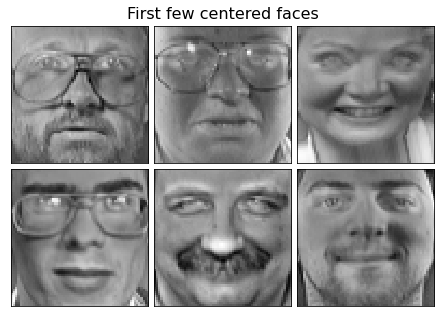

In [887]:
plot_gallery("First few centered faces", X[:n_components])

In [888]:
#Find all sensor locations using built in QR optimizer
max_const_sensors = 230
n_const_sensors = 2
n_sensors = 10
optimizer  = ps.optimizers.QR()
model = ps.SSPOR(optimizer=optimizer, n_sensors=n_sensors)
model.fit(X)

all_sensors = model.get_all_sensors()
top_sensors0 = model.get_selected_sensors()
print('Unconstrained Optimal sensors, n = {}, {},...'.format(len(all_sensors),all_sensors[:n_sensors+3]))
print('Unconstrained Optimal sensors, n = {}, {}'.format(len(top_sensors0),top_sensors0))

Unconstrained Optimal sensors, n = 4096, [4032  384 4092 4039  447  493 2204  657  878 2880 1088 4087 2837],...
Unconstrained Optimal sensors, n = 10, [4032  384 4092 4039  447  493 2204  657  878 2880]


In [889]:
##Constrained sensor location on the grid: 
xmin = 20
xmax = 40
ymin = 25
ymax = 45
sensors_constrained = ps.optimizers._gqr.getConstraindSensorsIndices(xmin,xmax,ymin,ymax,nx,ny,all_sensors) #Constrained column indices
print('The constrained sensors are {}'.format(sensors_constrained))
print('The constrained sensors are {}'.format(top_sensors0[np.isin(top_sensors0,sensors_constrained,invert=False)]))

The constrained sensors are [1826 1765 1695 2084 1704 2529 2404 2210 1888 2406 1892 2402 2721 2022
 2398 1699 2454 1895 2661 2847 2589 2532 1697 2018 2272 1638 1621 2592
 2461 2214 1749 2326 1692 2408 1636 2015 2267 2659 2276 2780 1885 2456
 2464 1760 2004 2536 2394 2270 2088 2516 2388 2405 2716 2727 1635 2087
 2791 2599 2787 2901 2651 2595 2856 2774 2914 1878 1762 2471 1625 2342
 2527 2137 2197 1634 2583 1947 1823 1818 2327 2789 1750 2335 2400 1832
 1684 2584 2073 1624 2273 2660 2334 2708 2139 2085 2080 2339 1828 2790
 2263 1686 2081 2324 2014 2399 2836 2905 2916 2907 1693 2585 2462 2009
 2470 2781 2140 2208 2013 2535 2141 2920 2526 2275 2600 1639 2715 2710
 2330 2206 2778 1627 2919 2521 2784 2524 1946 1822 1629 2076 2020 2663
 2467 2518 2658 2391 1814 2854 1825 2726 2717 2719 2647 2469 2597 1819
 2401 2134 2072 1630 2590 2525 2772 2403 2274 1817 2332 2211 2340 1877
 2393 2530 1755 1830 1951 2010 2213 1876 2850 1831 1880 1890 2343 1754
 1955 2591 1950 2580 2902 2773 2207 2341 2338 278

In [890]:
class AQR(QR):
    """
    General QR optimizer for sensor selection.
    Ranks sensors in descending order of "importance" based on
    reconstruction performance. This is an extension that requires a more intrusive
    access to the QR optimizer to facilitate a more adaptive optimization. This is a generalized version of cost constraints
    in the sense that users can allow n constrained sensors in the constrained area.
    if n = 0 this converges to the CCQR results.

    See the following reference for more information
        Manohar, Krithika, et al.
        "Data-driven sparse sensor placement for reconstruction:
        Demonstrating the benefits of exploiting known patterns."
        IEEE Control Systems Magazine 38.3 (2018): 63-86.

    @ authors: Niharika Karnik (@nkarnik2999), Mohammad Abdo (@Jimmy-INL), and Krithika Manohar (@kmanohar)
    """
    def __init__(self,idx_constrained,n_sensors,const_sensors,all_sensors):
        """
        Attributes
        ----------
        pivots_ : np.ndarray, shape [n_features]
            Ranked list of sensor locations.
        idx_constrained : np.ndarray, shape [No. of constrained locations]
            Column Indices of the sensors in the constrained locations.
        n_sensors : integer, 
            Total number of sensors
        const_sensors : integer,
            Total number of sensors required by the user in the constrained region.
        """
        self.pivots_ = None
        self.constrainedIndices = idx_constrained
        self.nSensors = n_sensors
        self.nConstrainedSensors = const_sensors
        self.all_sensorloc = all_sensors

    def fit(
        self,
        basis_matrix
    ):
        """
        Parameters
        ----------
        basis_matrix: np.ndarray, shape [n_features, n_samples]
            Matrix whose columns are the basis vectors in which to
            represent the measurement data.
        optimizer_kws: dictionary, optional
            Keyword arguments to be passed to the qr method.

        Returns
        -------
        self: a fitted :class:`pysensors.optimizers.QR` instance
        """

        n_features, n_samples = basis_matrix.shape  # We transpose basis_matrix below
        max_const_sensors = len(self.constrainedIndices) #Maximum number of sensors allowed in the constrained region

        ## Assertions and checks:
        if self.nSensors > n_features - max_const_sensors + self.nConstrainedSensors:
            raise IOError ("n_sensors cannot be larger than n_features - all possible locations in the constrained area + allowed constrained sensors")
        if self.nSensors > n_samples + self.nConstrainedSensors: ## Handling zero constraint?
            raise IOError ("Currently n_sensors should be less than number of samples + number of constrained sensors,\
                           got: n_sensors = {}, n_samples + const_sensors = {} + {} = {}".format(n_sensors,n_samples,self.nConstrainedSensors,n_samples+self.nConstrainedSensors))

        # Initialize helper variables
        R = basis_matrix.conj().T.copy()
        p = np.arange(n_features)
        k = min(n_samples, n_features)


        for j in range(k):
            r = R[j:, j:]
            # Norm of each column
            dlens = np.sqrt(np.sum(np.abs(r) ** 2, axis=0))
            dlens_updated = f_region_updated(self.constrainedIndices,dlens,p,j, self.nConstrainedSensors,self.all_sensorloc,self.nSensors) #Handling constrained region sensor placement problem

            # Choose pivot
            i_piv = np.argmax(dlens_updated)
          
            dlen = dlens_updated[i_piv]

            if dlen > 0:
                u = r[:, i_piv] / dlen
                u[0] += np.sign(u[0]) + (u[0] == 0)
                u /= np.sqrt(abs(u[0]))
            else:
                u = r[:, i_piv]
                u[0] = np.sqrt(2)

            # Track column pivots
            i_piv += j # true permutation index is i_piv shifted by the iteration counter j
            p[[j, i_piv]] = p[[i_piv, j]]

            # Switch columns
            R[:, [j, i_piv]] = R[:, [i_piv, j]]

            # Apply reflector
            R[j:, j:] -= np.outer(u, np.dot(u, R[j:, j:]))
            R[j + 1 :, j] = 0

        self.pivots_ = p


        return self

In [891]:

def f_region_updated(lin_idx, dlens, piv, j, const_sensors,all_sensors,n_sensors):
    counter = 0
    mask = np.isin(all_sensors,lin_idx,invert=False)
    const_idx = all_sensors[mask]
    updated_lin_idx = const_idx[const_sensors:]
    var = np.isin(all_sensors[:n_sensors],lin_idx, invert=False)
    n = np.count_nonzero(var)
    print(n)


    if any(var) == False:
        if j < const_sensors:
            didx = np.isin(piv[j:],lin_idx,invert=True)
            dlens[didx] = 0
        else:
            didx = np.isin(piv[j:],lin_idx,invert=False)
            dlens[didx] = 0

    elif n >= const_sensors:
        for i in range(n_sensors):
            if np.isin(all_sensors[i],lin_idx,invert=False):
                counter += 1
                if counter < const_sensors:
                    dlens = dlens
            else:
                didx = np.isin(piv[j:],updated_lin_idx,invert=False)
                dlens[didx] = 0

    elif n < const_sensors:
        for i in range(n_sensors):
            if np.isin(all_sensors[i],lin_idx,invert=False):
                counter += 1
                if counter <= n:
                    dlens = dlens

                elif n <= counter and counter <= const_sensors:
                       
                        didx = np.isin(piv[j:],updated_lin_idx,invert=True)
                        dlens[didx] = 0
                else:
                    didx = np.isin(piv[j:],updated_lin_idx,invert=False)
                    dlens[didx] = 0

    return dlens

In [892]:
optimizer1 = AQR(sensors_constrained,n_sensors,n_const_sensors,all_sensors)
model1 = ps.SSPOR(optimizer = optimizer1, n_sensors = n_sensors)
model1.fit(X)
all_sensors1 = model1.get_all_sensors()

top_sensors = model1.get_selected_sensors()


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


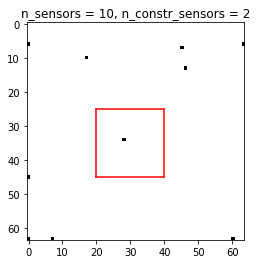

In [893]:
## TODO: this can be done using ravel and unravel more elegantly
img = np.zeros(n_features)
img[top_sensors] = 16
plt.plot([xmin,xmin],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymax,ymax],'r')
plt.plot([xmax,xmax],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymin,ymin],'r')
plt.imshow(img.reshape(image_shape),cmap=plt.cm.binary)
plt.title('n_sensors = {}, n_constr_sensors = {}'.format(n_sensors,n_const_sensors))
plt.show()

In [894]:
print(top_sensors0)
c = np.zeros([len(top_sensors0),n_features])
print(c.shape)
for i in range(len(top_sensors0)):
    c[i,top_sensors0[i]] = 1
phi = model.basis_matrix_
optimality = np.linalg.det((c@phi).T @ (c@phi))
print(optimality)

[4032  384 4092 4039  447  493 2204  657  878 2880]
(10, 4096)
0.0


In [895]:
print(top_sensors)
c1 = np.zeros([len(top_sensors),n_features])
print(c1.shape)
for i in range(len(top_sensors)):
    c1[i,top_sensors[i]] = 1
phi1 = model1.basis_matrix_
optimality1 = np.linalg.det((c1@phi1).T @ (c1@phi1))
print(optimality1)

[4032  384 4092 4039  447  493 2204  657  878 2880]
(10, 4096)
0.0


In [896]:
test_sensors = [4032, 384, 4092, 4039, 447, 493, 657, 878, 2880, 1088]

In [897]:
np.linalg.norm((X - model1.predict(X[:,top_sensors0])))/np.linalg.norm(X)

0.79669476

In [898]:
np.linalg.norm((X - model1.predict(X[:,top_sensors])))/np.linalg.norm(X)

0.79669476

In [899]:
np.linalg.norm((X - model1.predict(X[:,test_sensors])))/np.linalg.norm(X)

0.88171

In [900]:
test_sensors2  = [x for x in all_sensors if x not in sensors_constrained][n_const_sensors:n_sensors]

In [901]:
np.linalg.norm((X - model1.predict(X[:,test_sensors2])))/np.linalg.norm(X)

ValueError: x has the wrong number of features: 8.
                Expected 10

In [ ]:
XX = np.zeros_like(X)
XX[:,top_sensors] = X[:,top_sensors]
model1.score(XX)

-0.0730837